Here we compare multicriterial selection for counterfactuals with single ones.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import pickle
from rf_counterfactuals import RandomForestExplainer, visualize, evaluate_counterfactual, evaluate_counterfactual_set
from rf_counterfactuals.single_cf_costs_functions import heterogeneous_euclidean_overlap_metric, unmatched_components_distance
from rf_counterfactuals.multi_cf_costs_functions import diversity
import os
from collections import defaultdict

from sklearn import preprocessing
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, pairwise_distances
from sklearn.neighbors import NearestNeighbors
DATASET_PATH = "./datasets/"

N_JOBS = -1

# Comment one of two cells below to choose a dataset

In [2]:
# DATASET_NAME = 'Adult'

# adult_dataset = pd.read_csv(os.path.join(DATASET_PATH, "adult.csv"))

# class_feature = "income"
# feature_names = [c for c in adult_dataset.columns if c != class_feature]
# categorical_features = [1, 3, 5, 6, 7, 8, 9, 13]
# to_encode = [c for no, c in enumerate(feature_names) if no in categorical_features]

# d = defaultdict(preprocessing.LabelEncoder)

# adult_dataset[to_encode] = adult_dataset[to_encode].apply(lambda x: d[x.name].fit_transform(x))

# X = adult_dataset.loc[:, adult_dataset.columns!=class_feature]
# y = adult_dataset[class_feature]

In [3]:
DATASET_NAME = 'German'

COLUMNS = ['checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount', 'saving_account', 'present_employement',
          'installment_rate', 'personal_status', 'other_debtors', 'present_residence', 'property', 'age', 'installment_plans',
          'housing', 'existing_credits_number', 'job', 'people_to_provide_maintenance', 'has_telephone', 'foreign', 'risk']

german_dataset = pd.read_csv(os.path.join(DATASET_PATH, "german_data.csv"), sep=' ', names=COLUMNS)

class_feature = "risk"
categorical_features = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
to_encode = [c for no, c in enumerate(COLUMNS) if no in categorical_features]

d = defaultdict(preprocessing.LabelEncoder)

german_dataset[to_encode] = german_dataset[to_encode].apply(lambda x: d[x.name].fit_transform(x))

X = german_dataset.loc[:, german_dataset.columns!=class_feature]
y = german_dataset[class_feature]

# Calculations

In [4]:
from joblib import Parallel, delayed
from functools import partial

def calc_metrics(feature_range, cat, non_cat, X_primes, X):
    mean_hoem = np.mean([heterogeneous_euclidean_overlap_metric(X.values, X_prime.values, rfe.X_train_stats['range'],
                                                                  rfe.categorical_features,
                                                                  rfe.non_categorical_features) for _, X_prime in X_primes.iterrows()])
    
    d = diversity(X_primes, feature_range, cat, non_cat)
    return [mean_hoem, d]
   

CLASSES = y.unique()

SPLITS = 10

skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=1000)
eps = 0.1
categorical_features = [1, 3, 5, 6, 7, 8, 9, 13]
frozen_features = [8, 9]
left_frozen_features = [0]

scores = defaultdict(list)

accuracy = []
split = 0

total_found = defaultdict(list)

for train_index, test_index in skf.split(X, y):
    start_time = time.time()
    print(split+1, "/", SPLITS)
    split += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=100, max_depth=5)
    rf.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_test, rf.predict(X_test)))

    
    y_hat = rf.predict(X_test)
    X_test_0 = X_test[y_hat==CLASSES[0]]
    X_test_1 = X_test[y_hat==CLASSES[1]]

    
    rfe = RandomForestExplainer(rf, X_train, y_train, categorical_features=categorical_features, 
                                        left_frozen_features=left_frozen_features, frozen_features=frozen_features)
    
    
    cfs0 = rfe.explain_with_multiple_metrics(X_test_0, CLASSES[1], eps=eps, k=5, metrics=('hoem', 'unmatched_components'), n_jobs=N_JOBS)
    cfs1 = rfe.explain_with_multiple_metrics(X_test_1, CLASSES[0], eps=eps, k=5, metrics=('hoem', 'unmatched_components'), n_jobs=N_JOBS)

    found_0 = sum([1 for i in range(len(cfs0)) if len(cfs0[i]) >= 2])
    found_1 = sum([1 for i in range(len(cfs1)) if len(cfs1[i]) >= 2])
    
    total_found['0'] += [found_0, len(cfs0)]
    total_found['1'] += [found_1, len(cfs1)]
    
    print(f"found_0: {found_0} / {X_test_0.shape[0]}")
    print(f"found_1: {found_1} / {X_test_1.shape[0]}")
    
    
    rfe = RandomForestExplainer(rf, X_train, y_train, categorical_features=categorical_features, 
                                        left_frozen_features=left_frozen_features, frozen_features=frozen_features)
    
    cfs0_single_hoem = rfe.explain_with_single_metric(X_test_0, CLASSES[1], eps=eps, metric='hoem', k=5, limit=None, n_jobs=N_JOBS)
    cfs1_single_hoem = rfe.explain_with_single_metric(X_test_1, CLASSES[0], eps=eps, metric='hoem', k=5, limit=None, n_jobs=N_JOBS)
    
    rfe = RandomForestExplainer(rf, X_train, y_train, categorical_features=categorical_features, 
                                        left_frozen_features=left_frozen_features, frozen_features=frozen_features)
    
    cfs0_single_ucr = rfe.explain_with_single_metric(X_test_0, CLASSES[1], eps=eps, metric='unmatched_components', k=5, limit=None, n_jobs=N_JOBS)
    cfs1_single_ucr = rfe.explain_with_single_metric(X_test_1, CLASSES[0], eps=eps, metric='unmatched_components', k=5, limit=None, n_jobs=N_JOBS)
    
#     cfs0_single_im = rfe.explain_with_single_metric(X_test_0, CLASSES[1], eps=eps, metric='implausibility_single', k=5, limit=None, n_jobs=N_JOBS)
#     cfs1_single_im = rfe.explain_with_single_metric(X_test_1, CLASSES[0], eps=eps, metric='implausibility_single', k=5, limit=None, n_jobs=N_JOBS)
    

    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs0[i], X_test_0.iloc[i]) for i in range(len(cfs0)) if len(cfs0[i]) >= 2)
    scores['multi0'].append(results)
    
    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs1[i], X_test_1.iloc[i]) for i in range(len(cfs1)) if len(cfs1[i]) >= 2)
    scores['multi1'].append(results)

    
    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs0_single_hoem[i].iloc[:len(cfs0[i])], X_test_0.iloc[i]) for i in range(len(cfs0)) if len(cfs0[i]) >= 2)
    scores['hoem0'].append(results)

    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs1_single_hoem[i].iloc[:len(cfs1[i])], X_test_1.iloc[i]) for i in range(len(cfs1)) if len(cfs1[i]) >= 2)
    scores['hoem1'].append(results)
    
    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs0_single_ucr[i].iloc[:len(cfs0[i])], X_test_0.iloc[i]) for i in range(len(cfs0)) if len(cfs0[i]) >= 2)
    scores['uc0'].append(results)
    
    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs1_single_ucr[i].iloc[:len(cfs1[i])], X_test_1.iloc[i]) for i in range(len(cfs1)) if len(cfs1[i]) >= 2)
    scores['uc1'].append(results)
    

    print("Split time: ", time.time() - start_time, "s")


    
    

accuracy_mean, accuracy_std = np.mean(accuracy), np.std(accuracy)
accuracy_mean

1 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


[3/3] Calculating loss function. Total number of tasks: 89


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0285s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  74 out of  89 | elapsed:    3.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  83 out of  89 | elapsed:    3.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    3.5s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


[3/3] Calculating loss function. Total number of tasks: 11


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    1.7s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    1.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    2.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.0s finished


found_0: 0 / 89
found_1: 1 / 11
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


[3/3] Calculating loss function. Total number of tasks: 89


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0259s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 out of  89 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  83 out of  89 | elapsed:    2.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    3.0s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


[3/3] Calculating loss function. Total number of tasks: 11


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    1.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    1.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    2.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    2.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.9s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


[3/3] Calculating loss function. Total number of tasks: 89


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0179s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1831s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  65 out of  89 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.7s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


[3/3] Calculating loss function. Total number of tasks: 11


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.7s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.3s finished


Split time:  52.43811082839966 s
2 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:    3.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.3s finished


found_0: 0 / 92
found_1: 5 / 8
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0051s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:    3.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    1.8s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1730s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  92 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    1.8s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished


Split time:  50.93117427825928 s
3 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


[3/3] Calculating loss function. Total number of tasks: 93


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0249s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  78 out of  93 | elapsed:    3.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  88 out of  93 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    4.4s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished


[3/3] Calculating loss function. Total number of tasks: 7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.7s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.1s finished


found_0: 1 / 93
found_1: 3 / 7
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


[3/3] Calculating loss function. Total number of tasks: 93


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0269s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  78 out of  93 | elapsed:    2.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  88 out of  93 | elapsed:    3.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    3.7s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished


[3/3] Calculating loss function. Total number of tasks: 7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    2.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.2s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished


[3/3] Calculating loss function. Total number of tasks: 93


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0177s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1821s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  88 out of  93 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    1.8s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


[3/3] Calculating loss function. Total number of tasks: 7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished


Split time:  55.48637866973877 s
4 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0269s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:    3.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  87 out of  92 | elapsed:    3.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.7s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.4s finished


found_0: 0 / 92
found_1: 2 / 8
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0263s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:    3.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  87 out of  92 | elapsed:    3.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.7s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.4s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1701s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  92 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    1.6s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.0s finished


Split time:  53.145753622055054 s
5 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


[3/3] Calculating loss function. Total number of tasks: 90


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0294s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1896s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


[3/3] Calculating loss function. Total number of tasks: 10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.1s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


found_0: 0 / 90
found_1: 4 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


[3/3] Calculating loss function. Total number of tasks: 90


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0308s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1827s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


[3/3] Calculating loss function. Total number of tasks: 10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.0s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


[3/3] Calculating loss function. Total number of tasks: 90


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0249s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0850s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


[3/3] Calculating loss function. Total number of tasks: 10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


Split time:  54.13099002838135 s
6 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1862s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


[3/3] Calculating loss function. Total number of tasks: 88


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0222s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  82 out of  88 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished


[3/3] Calculating loss function. Total number of tasks: 12


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    2.6s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    2.8s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    4.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.4s finished


found_0: 0 / 88
found_1: 0 / 12
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1574s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


[3/3] Calculating loss function. Total number of tasks: 88


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0174s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  82 out of  88 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:    2.6s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    7.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished


[3/3] Calculating loss function. Total number of tasks: 12


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    2.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    2.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    3.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.4s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1723s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


[3/3] Calculating loss function. Total number of tasks: 88


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0106s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1615s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  73 out of  88 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  82 out of  88 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:    1.1s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished


[3/3] Calculating loss function. Total number of tasks: 12


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    1.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    1.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    1.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.8s finished


Split time:  55.71867060661316 s
7 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished


[3/3] Calculating loss function. Total number of tasks: 89


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0259s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  74 out of  89 | elapsed:    3.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


[3/3] Calculating loss function. Total number of tasks: 11


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    2.1s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    2.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    2.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    2.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.6s finished


found_0: 2 / 89
found_1: 0 / 11
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1575s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished


[3/3] Calculating loss function. Total number of tasks: 89


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0267s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  74 out of  89 | elapsed:    3.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  83 out of  89 | elapsed:    3.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    3.7s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


[3/3] Calculating loss function. Total number of tasks: 11


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    2.0s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    2.2s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    2.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    2.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.5s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1618s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished


[3/3] Calculating loss function. Total number of tasks: 89


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0182s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  83 out of  89 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.5s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


[3/3] Calculating loss function. Total number of tasks: 11


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.4s finished


Split time:  57.25522041320801 s
8 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


[3/3] Calculating loss function. Total number of tasks: 91


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0151s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  76 out of  91 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  86 out of  91 | elapsed:    3.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    3.3s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


[3/3] Calculating loss function. Total number of tasks: 9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    2.4s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.4s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    2.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    2.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.3s finished


found_0: 0 / 91
found_1: 5 / 9
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


[3/3] Calculating loss function. Total number of tasks: 91


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0167s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  76 out of  91 | elapsed:    2.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  86 out of  91 | elapsed:    2.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    3.3s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


[3/3] Calculating loss function. Total number of tasks: 9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.2s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    2.3s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    2.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    2.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.2s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished


[3/3] Calculating loss function. Total number of tasks: 91


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1792s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  66 out of  91 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  76 out of  91 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  86 out of  91 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.4s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


[3/3] Calculating loss function. Total number of tasks: 9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    0.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.3s finished


Split time:  56.193217515945435 s
9 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


[3/3] Calculating loss function. Total number of tasks: 85


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0205s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1755s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 out of  85 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  61 out of  85 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished


[3/3] Calculating loss function. Total number of tasks: 15


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    1.9s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    2.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    4.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    4.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.5s finished


found_0: 0 / 85
found_1: 6 / 15
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1948s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


[3/3] Calculating loss function. Total number of tasks: 85


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0206s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1930s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 out of  85 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  61 out of  85 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished


[3/3] Calculating loss function. Total number of tasks: 15


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    1.8s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    2.4s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    4.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    4.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.5s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1865s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


[3/3] Calculating loss function. Total number of tasks: 85


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0148s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0814s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 out of  85 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  61 out of  85 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished


[3/3] Calculating loss function. Total number of tasks: 15


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    0.7s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    1.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    1.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.7s finished


Split time:  56.989999294281006 s
10 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1992s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0106s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:    2.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s finished


found_0: 0 / 92
found_1: 4 / 8
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1962s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0054s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:    2.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1699s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


[3/3] Calculating loss function. Total number of tasks: 92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0063s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1108s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  67 out of  92 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


[3/3] Calculating loss function. Total number of tasks: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished


Split time:  50.27286458015442 s


0.743

In [5]:
sum(total_found['0'][1::2])

901

In [6]:
sum(total_found['1'][1::2])

99

In [7]:
import itertools

scores2 = {}

for key, value in scores.items():
    score = np.array(list(itertools.chain.from_iterable(value)))
#     print(score)
    
    scores2[key] = score

scores2

{'multi0': array([[0.20531909, 0.23478399],
        [0.11081489, 0.16719813],
        [0.94195922, 1.25523998]]),
 'multi1': array([[0.48636717, 0.69231306],
        [0.62455807, 1.0305624 ],
        [0.1854136 , 0.26423018],
        [0.40122144, 0.60122504],
        [0.46221376, 0.66328363],
        [0.4959919 , 0.70442125],
        [0.83733724, 1.20631076],
        [0.36166397, 0.51462562],
        [0.45401501, 0.55080266],
        [0.38747152, 0.58975942],
        [0.50778018, 0.71970621],
        [0.19236254, 0.27300756],
        [0.30586315, 0.45325875],
        [0.76922713, 1.04002425],
        [0.32614191, 0.47342491],
        [0.20569767, 0.29093356],
        [0.2026732 , 0.28675422],
        [0.40016925, 0.36630817],
        [0.46248736, 0.65431059],
        [0.09353942, 0.15591286],
        [0.43976648, 0.42611565],
        [0.22597959, 0.25108712],
        [0.11623178, 0.14154288],
        [0.17325339, 0.07492944],
        [0.30677913, 0.45420607],
        [0.33278752, 0.261

In [8]:
scores3 = {'multi': np.vstack([scores2['multi0'], scores2['multi1']]),
          'hoem': np.vstack([scores2['hoem0'], scores2['hoem1']]),
          'uc': np.vstack([scores2['uc0'], scores2['uc1']])
          }

In [9]:
total_found_num = sum(total_found['0'][::2]) + sum(total_found['1'][::2])
total_found_denum = sum(total_found['0'][1::2]) + sum(total_found['1'][1::2])

total_found_num, total_found_denum

(33, 1000)

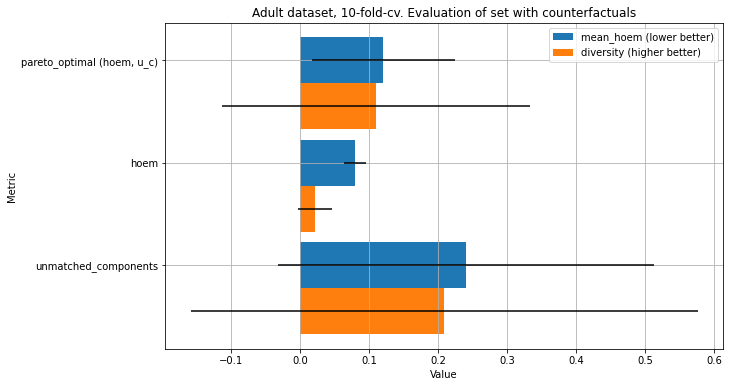

In [14]:
# XLABELS = [f"pareto {CLASSES[0]} -> {CLASSES[1]}", f"pareto {CLASSES[0]} -> {CLASSES[1]}", f"hoem {CLASSES[0]} -> {CLASSES[1]}",
#            f"hoem {CLASSES[0]} -> {CLASSES[1]}", f"unmatched_components {CLASSES[0]} -> {CLASSES[1]}", f"unmatched_components {CLASSES[0]} -> {CLASSES[1]}"]

XLABELS = [f"pareto_optimal (hoem, u_c)", f"hoem", f"unmatched_components"]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
y_pos = np.arange(len(scores3.keys()))
# means = np.array([np.mean(s, axis=0) for s in scores3.values()])
# stds = np.array([np.std(s, axis=0) for s in scores3.values()])

width=0.45


plt.barh(y_pos, means[:, 0], width, xerr=stds[:, 0], label='mean_hoem (lower better)')
plt.barh(y_pos+width, means[:, 1], width, xerr=stds[:, 1], label='diversity (higher better)')

ax.set_yticks(y_pos, labels=XLABELS)
ax.legend()
ax.grid()
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Value')
ax.set_ylabel("Metric")
ax.set_title(f"{DATASET_NAME} dataset, {SPLITS}-fold-cv. Evaluation of set with counterfactuals")

plt.show()

In [ ]:
for no, metric in enumerate(XLABELS):
    print(f"{metric} & {means[no, 0]:1.3f}({stds[no, 0]:1.3f}) & {means[no, 1]:1.3f}({stds[no, 1]:1.3f}) \\\\")